In [1]:
import sys
import os 

os.environ["CONFIG_PATHS"] = "../configs/self_play_20.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../data/moves_20_regen_2"'
sys.path.append("../src")

from display import Display
from neural_net import NeuralNet
import player_pov_helpers
from training.load_games import load_games

from configuration import moves_data, config

Loaded config:  {"development": {"debug_mode": true, "profile": false, "runtime": 0, "display_logs_in_console": false, "output_directory": "data/2024-12-30_23-23-24-rubefaction"}, "logging": {"save_interval": 600, "mcts_report_fraction": 0, "ucb_report": false, "gpu_evaluation": true, "made_move": true}, "game": {"board_size": 20, "num_moves": 30433, "num_pieces": 21, "moves_directory": "../data/moves_20_regen_2"}, "architecture": {"gameplay_processes": 6, "coroutines_per_process": 256, "game_flush_threshold": 50}, "training": {"run": true, "network_name": "default", "batch_size": 128, "policy_loss_weight": 0.158, "learning_rate": 0.001, "sample_window": 50000, "samples_per_generation": 10000, "sampling_ratio": 2.0, "minimum_window_size": 10000, "new_data_check_interval": 60}, "networks": {"default": {"main_body_channels": 64, "value_head_channels": 16, "value_head_flat_layer_width": 64, "policy_head_channels": 32, "residual_blocks": 10, "model_path": "", "model_directory": "data/2024-

In [2]:
b = moves_data()["new_occupieds"].tobytes()

In [3]:
import hashlib

hashlib.sha256(b).hexdigest()

'eb2398d1bdebe75baf6e55e2883eead3abc88dc55ae732711ffa93623961ad73'

In [7]:
len(set(moves_data()["piece_orientation_indices"]))

91

In [16]:
import torch
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

In [17]:
def load_games(game_file_paths):
    occupancies = []
    policies = []
    final_game_values = []
    average_rollout_values = []
    valid_moves_array = []
    game_ids = []

    for game_file in game_file_paths:
        with open(game_file, "rb") as f:
            npz = np.load(f)
            occupancies.append(npz["occupancies"])
            policies.append(npz["policies"])
            final_game_values.append(npz["final_game_values"])
            average_rollout_values.append(npz["average_rollout_values"])
            game_ids.append(npz["game_ids"])
            valid_moves_array.append(npz["valid_moves_array"])

    return (
        np.concatenate(occupancies),
        np.concatenate(policies),
        np.concatenate(final_game_values),
        np.concatenate(average_rollout_values),
        np.concatenate(valid_moves_array),
    )


boards, policies, final_game_values, average_rollout_values, valid_moves_array = load_games([
    "../data/2024-11-26_22-50-22-halebi/games/1732690842003_2.npz",
])

In [18]:
np.any(policies[1][~valid_moves_array[1]])

np.False_

In [19]:
boards, policies, final_game_values, average_rollout_values = gamedata

NameError: name 'gamedata' is not defined

In [39]:
# np.savez(
#     "/tmp/raw.npz",
#     occupancies=boards,
#     policies=policies,
#     final_game_values=final_game_values,
#     average_rollout_values=average_rollout_values,
# )
np.savez_compressed(
    "/tmp/raw_compressed.npz",
    game_ids=np.zeros(5),
    occupancies=boards,
    policies=policies,
    final_game_values=final_game_values,
    average_rollout_values=average_rollout_values,
)

In [46]:
!ls -lh /tmp/raw*.npz

-rw-r--r--@ 1 shivamsarodia  wheel    39M Nov 26 20:28 /tmp/raw.npz
-rw-r--r--@ 1 shivamsarodia  wheel   222K Nov 26 22:57 /tmp/raw_compressed.npz


In [30]:
13.2 / 81000

0.00016296296296296295

In [40]:
gamedata2 = load_games([
    "/tmp/raw_compressed.npz",
])
boards2, policies2, final_game_values2, average_rollout_values2 = gamedata2

In [43]:
boards2.shape == boards.shape

True

In [45]:
print((boards2 == boards).all())
print((policies2 == policies).all())
print((final_game_values2 == final_game_values).all())
print((average_rollout_values2 == average_rollout_values).all())


True
True
True
True


In [137]:
for board in occupancies:
    if np.sum(board[0]) == 5:
        print(board[0])

[[ True  True False False False False False False False False]
 [False  True  True False False False False False False False]
 [False False  True False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]]
[[ True  True False False False False False False False False]
 [False  True  True  True False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False Fals

In [109]:
Event = namedtuple('Event', [
    'timestamp',
    'name',
    'params',
]) 

def load_events(log_path):
    events = []
    with open(log_path) as f:
        logs = f.readlines()
        for line in logs:
            # Skip lines that are not events.
            if not line.startswith("event | "):
                continue

            _, timestamp, event, params = line.strip().split(" | ")
            events.append((float(timestamp), event, json.loads(params)))

    # Sort events by timestamp.
    events.sort(key=lambda x: x[0])

    # Adjust timestamps to start at 0.
    start_time = events[0][0]
    print(f"Start time: {start_time}")

    return [
        Event(
            timestamp=timestamp - start_time,
            name=event,
            params=params,
        )
        for timestamp, event, params in events
    ]

In [15]:
MOVES = moves_data()

In [13]:
# first move, by player 0: 2942
# second move, by player 1 recommended by the policy network: 2914 (in universal)

gamefile = np.load("../data/2024-11-29_23-05-39-erpetologist/games/1732950430040_4.npz")
boards = gamefile["boards"]
policies = gamefile["policies"]
values = gamefile["values"]
unused_pieces = gamefile["unused_pieces"]

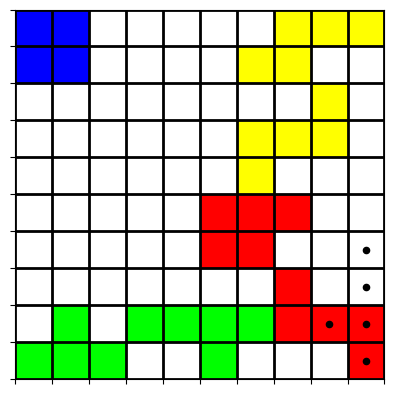

In [29]:
i = 1

used_pieces = ~unused_pieces[i][3]

move_index = np.flatnonzero(MOVES["piece_indices"] == np.flatnonzero(used_pieces)[0])[0]

Display(
    boards[i],
    MOVES["new_occupieds"][move_index],
).show()

In [62]:
np.argmax(policies[0])

np.int64(2942)

In [85]:
model = NeuralNet(config()["networks"]["default"])
model.load_state_dict(torch.load("../data/2024-11-20_17-29-54-solitude/models/2024-11-20_08-24-43_975055.pt", weights_only=True))

<All keys matched successfully>

In [89]:
model.eval()
values, policies = model(torch.Tensor(occupancies))

In [103]:
torch.softmax(values[0], dim=0)

tensor([0.4902, 0.1406, 0.3062, 0.0631], grad_fn=<SoftmaxBackward0>)

In [104]:
torch.argmax(policies[0])

tensor(2942)

In [114]:
events = 

Start time: 1732155183.77021


In [115]:
reports = [event for event in events if event.name == "mcts_report"]

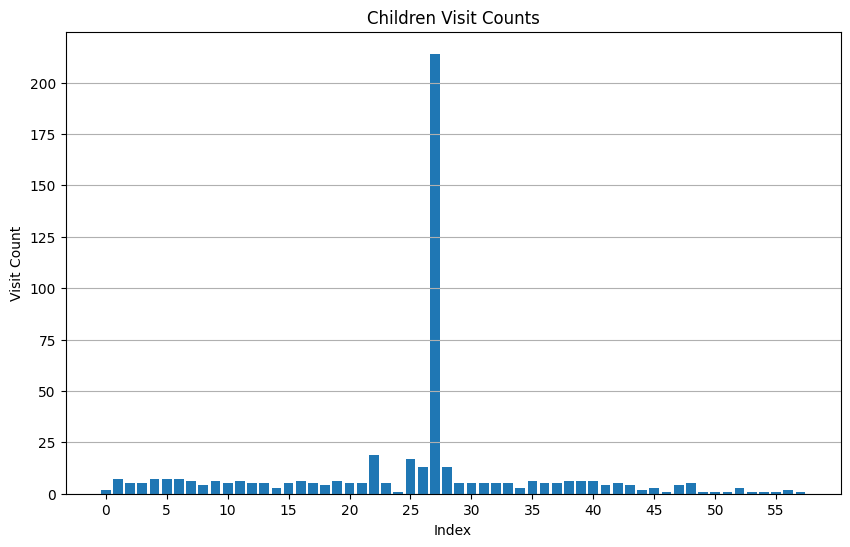

In [122]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(reports[0].params["children_visit_counts"])), reports[0].params["children_visit_counts"])
plt.title("Children Visit Counts")
plt.xlabel("Index")
plt.ylabel("Visit Count")
plt.xticks(range(0, len(reports[0].params["children_visit_counts"]), 5))
plt.grid(True, axis='y')
plt.show()


In [23]:
gamedata_path = "/Users/shivamsarodia/Dev/blockus/data/2024-11-20_23-29-01-chickpea/games"
gamedata_paths = [
    os.path.join(gamedata_path, filename)
    for filename in os.listdir(gamedata_path)
    if filename.endswith(".npz")
]
len(gamedata_paths)

603

In [17]:
games = load_games(gamedata_paths)

In [22]:
games[2].size

2058724

In [31]:
# First, check what game data files are available.
gamedata_paths = [
    os.path.join(gamedata_path, filename)
    for filename in os.listdir(gamedata_path)
    if filename.endswith(".npz")
]

paths_with_sample_counts = [
    (path, int(path.split("_")[-1].split(".")[0]))
    for path in gamedata_paths
]

total_sample_count = sum(count for path, count in paths_with_sample_counts)

In [32]:
total_sample_count

514681

In [27]:
total_samples_available

514681

(array([1710., 1860., 1906., 2124., 2188., 2289., 2464., 2554., 2621.,
        2832., 2868., 2862., 2670., 2590., 2627., 2584., 2621., 2336.,
        2408., 2297., 2414., 2421., 2366., 2427., 2477., 2337., 2389.,
        2382., 2468., 2453., 2471., 2353., 2479., 2497., 2489., 2424.,
        2357., 2371., 2576., 2403., 2401., 2520., 2493., 2386., 2421.,
        2393., 2424., 2369., 2440., 2369., 2416., 2407., 2393., 2478.,
        2392., 2348., 2417., 2374., 2470., 2429., 2524., 2443., 2514.,
        2465., 2423., 2531., 2360., 2376., 2477., 2363., 2394., 2445.,
        2417., 2344., 2398., 2475., 2462., 2377., 2467., 2465., 2366.,
        2507., 2430., 2384., 2402., 2435., 2450., 2367., 2461., 2485.,
        2406., 2455., 2520., 2413., 2384., 2468., 2346., 2455., 2378.,
        2462., 2453., 2475., 2421., 2431., 2403., 2355., 2442., 2425.,
        2485., 2391., 2386., 2353., 2443., 2506., 2462., 2414., 2425.,
        2479., 2394., 2438., 2428., 2365., 2495., 2454., 2360., 2415.,
      

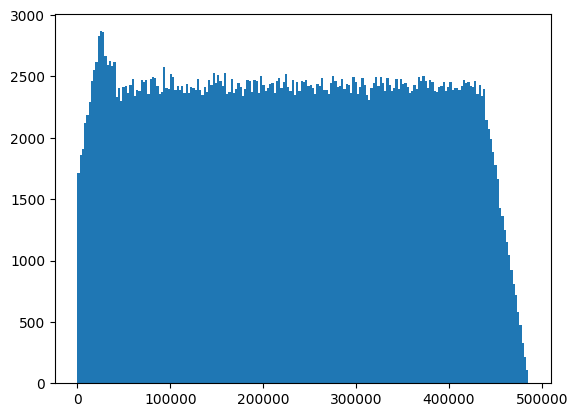

In [15]:
import random

data = [0]
samples = []

window_size = 50000

for _ in range(500):
    new_sample_count = random.randint(1, 2000)

    # New set of samples comes in.
    # Add these to our running data.
    for _ in range(new_sample_count):
        data.append(data[-1] + 1)
    
    # Remove data that's outside the window.
    data = data[-window_size:]

    # We sample data points.
    if len(data) >= window_size / 2:
        samples += random.choices(data, k=new_sample_count)

plt.hist(samples, bins=200)

In [13]:
from collections import Counter

data = Counter(samples)

In [14]:
data.most_common(50)

[(470, 11),
 (1957, 11),
 (4280, 11),
 (894, 10),
 (349, 10),
 (1745, 10),
 (1221, 10),
 (411, 10),
 (491, 10),
 (967, 10),
 (436, 10),
 (314, 10),
 (230, 10),
 (207, 10),
 (125, 10),
 (1507, 10),
 (3862, 10),
 (4590, 10),
 (4679, 10),
 (6419, 10),
 (17, 9),
 (130, 9),
 (321, 9),
 (1275, 9),
 (721, 9),
 (1198, 9),
 (1502, 9),
 (158, 9),
 (869, 9),
 (862, 9),
 (304, 9),
 (1343, 9),
 (1046, 9),
 (178, 9),
 (1040, 9),
 (286, 9),
 (1312, 9),
 (1579, 9),
 (1458, 9),
 (1219, 9),
 (1516, 9),
 (1704, 9),
 (548, 9),
 (697, 9),
 (2192, 9),
 (2764, 9),
 (781, 9),
 (1385, 9),
 (4177, 9),
 (1461, 9)]

In [7]:
import numpy as np 

unused_pieces = np.zeros((4, 7, 7))
unused_pieces[0][0][0] = 5

player_pov_helpers.unused_pieces_to_player_pov(unused_pieces, 1)

array([[[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[5., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
      

In [1]:
model_sample_counts_to_select = [
    200000,
    400000,
    800000,
    1000000,
    1100000,
    1200000,
    1300000,
    1400000,
    1500000,
    1600000,
    1700000,
    1800000,
    1900000,
    2000000,
    2100000,
    2190000,
]
current_sample_count_index = 0

import glob

model_files = glob.glob('/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/*.pt')
model_files.sort()

selected_model_files = {}

for model_file in model_files:
    model_file_sample_count = int(model_file.split("/")[-1].split(".")[0])
    if model_file_sample_count > model_sample_counts_to_select[current_sample_count_index]:
        selected_model_files[model_file_sample_count] = model_file
        current_sample_count_index += 1

print("Num model files:", len(selected_model_files))

print("individual_networks:")
for sample_count, model_file in selected_model_files.items():
    print(f"  \"{sample_count}\":")
    print(f"    model_path: \"{model_file}\"")

print("individual_agents:")
for sample_count, model_file in selected_model_files.items():
    print(f"  - name: \"{sample_count}\"")
    print(f"    network: \"{sample_count}\"")

Num model files: 16
individual_networks:
  "204325":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/000204325.pt"
  "403006":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/000403006.pt"
  "808640":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/000808640.pt"
  "1005949":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001005949.pt"
  "1110265":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001110265.pt"
  "1204743":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001204743.pt"
  "1309389":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001309389.pt"
  "1400050":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_0

individual_networks:
  "204325":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/000204325.pt"
  "403006":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/000403006.pt"
  "808640":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/000808640.pt"
  "1005949":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001005949.pt"
  "1110265":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001110265.pt"
  "1204743":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001204743.pt"
  "1309389":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehandedness/models/001309389.pt"
  "1400050":
    model_path: "/Users/shivamsarodia/Dev/blockus/data/2024-11-23_00-37-50-doublehanded

In [4]:
model_files[0]

'../data/2024-11-23_00-37-50-doublehandedness/models/0.pt'